In [1]:
%run init.ipy

#jax.config.update('jax_platform_name', 'cpu')

from lib import constants
from lib import klatt
from lib import util
import random
from vtr.prior import formant
from lib import timit
from inv import process
from inv import model
from vtr.prior import filter

2023-02-15 17:19:13.984769: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-15 17:19:13.984857: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-15 17:19:13.984866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()

[Memory]9.6s, 0.2min    : Loading get_aplawd_training_pairs_subset...
[Memory]101.5s, 1.7min  : Loading run_nested...
[Memory]107.2s, 1.8min  : Loading run_nested...
[Memory]113.0s, 1.9min  : Loading run_nested...
[Memory]118.1s, 2.0min  : Loading run_nested...
NP = 3
Number of data points: 178
Number of model dimensions: 50


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 32,
  'use_oq': True,
  'impose_null_integral': True},
 PoleZeroFilter(3))

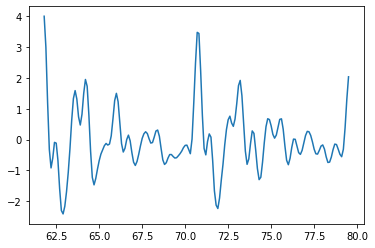

In [3]:
source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 32,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.PZ(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

hyper = process.make_rand_hyper(
    (fb_file, phn_file, wav_file),
    source_config = source_config,
    vtfilter = vtfilter,
    process_data_kwargs=dict(max_NP = 3, prepend=1)
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

## Try MAP with optax in $R^n$

Gradients seem to work when `impose_null_integral = False`!!

In [4]:
import jaxopt
import jax.scipy

In [5]:
ndim = model.ndim(hyper)
print(ndim)
theta_bijector = model.theta_trajectory_bijector(hyper)

def logabsdet_delw_deltheta(w):
    return -theta_bijector.forward_log_det_jacobian(w)

def loglike(w):
    """Return L(theta(w)) where a priori w ~ N(0, I)"""
    theta = theta_bijector.forward(w)
    logcorrection = logabsdet_delw_deltheta(w)
    loglikelihood = model.full_likelihood(theta, hyper)
    return loglikelihood + logcorrection

def logprior(w):
    return jnp.sum(jax.scipy.stats.norm.logpdf(w))

def minus_inf_if_nan(x):
    return jax.lax.cond(jnp.isnan(x), lambda: -jnp.inf, lambda: x)

def logjoint(w):
    lj = loglike(w) + logprior(w)
    return minus_inf_if_nan(lj)

# Test our likelihood and joint functions: OK
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())

l1 = model.full_likelihood(theta, hyper) + prior.log_prob(theta)

#
w = theta_bijector.inverse(theta)
l2 = logjoint(w)

#
l1, l2

50
[Memory]226.9s, 3.8min  : Loading get_aplawd_training_pairs_subset...
[Memory]228.7s, 3.8min  : Loading posterior_of_fitted_lf_values...
[Memory]229.8s, 3.8min  : Loading run_nested...
[Memory]230.8s, 3.8min  : Loading get_aplawd_training_pairs_subset...
[Memory]255.0s, 4.2min  : Loading posterior_of_fitted_TFB_values...
[Memory]256.1s, 4.3min  : Loading run_nested...
[Memory]256.3s, 4.3min  : Loading get_vtrformants_training_data...
[Memory]305.8s, 5.1min  : Loading run_nested...
[Memory]309.5s, 5.2min  : Loading run_nested...
[Memory]313.1s, 5.2min  : Loading run_nested...
[Memory]316.7s, 5.3min  : Loading run_nested...
[Memory]317.1s, 5.3min  : Loading get_vtrformants_training_data...
[Memory]342.1s, 5.7min  : Loading posterior_of_fitted_lf_values...
[Memory]342.1s, 5.7min  : Loading run_nested...
[Memory]342.3s, 5.7min  : Loading posterior_of_fitted_TFB_values...
[Memory]342.4s, 5.7min  : Loading run_nested...


(DeviceArray(-6292.20835919, dtype=float64),
 DeviceArray(-6292.20835919, dtype=float64))

In [6]:
def objective(w):
    return -logjoint(w)

objective(randn(ndim))

DeviceArray(100182.99360044, dtype=float64)

In [7]:
solver = jaxopt.LBFGS(objective, maxiter=5000)
w0 = randn(ndim)/10.
res = jax.jit(solver.run)(w0)

In [8]:
res

OptStep(params=DeviceArray([ 4.55504972e+00,  6.01764642e-05, -4.86860092e+00,
             -3.99435873e-01, -2.22647809e-01, -5.92304453e+00,
             -5.42851073e-01, -2.94913750e-01, -3.54699089e-02,
             -1.51925910e-02, -1.06888715e-02, -7.65116364e+00,
             -6.30493956e-01, -3.51228345e-01, -8.98986093e-01,
             -1.08242019e-01, -2.43643471e-02,  1.01299182e+00,
              3.02700386e-01,  5.58079588e-02,  7.44224009e-02,
              5.80813223e-02,  8.97485659e-03, -4.38433100e+00,
             -5.81875790e-01, -1.12627177e-01, -3.32959214e+00,
             -3.74460629e-01, -7.15015706e-02, -4.71267343e+00,
             -5.07481868e-01, -9.60659118e-02,  6.30099433e-06,
             -4.67591470e-05,  1.29467880e-06,  3.24011937e-06,
              1.55940285e-06,  6.34670863e-06,  7.61228685e-06,
              5.36718844e-06,  1.05658407e-05,  8.39412458e-06,
              5.10574599e-05, -3.08960657e-06, -4.92098683e-06,
              3.11946146e

0	log L = -254.47383031305912	SNR [dB] = 0.8681317055165847


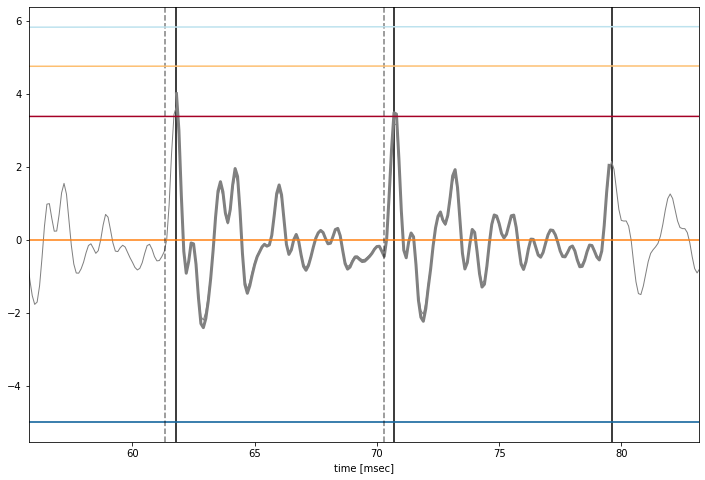

In [9]:
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

nsamp = 1

w_samples = [res.params]

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

In [10]:
theta_source, theta_filter

({'Oq': DeviceArray([0.3, 0.3, 0.3], dtype=float64),
  'T': DeviceArray([9.01307765, 8.98399703, 8.97469365], dtype=float64),
  'r': DeviceArray([0.00164177, 0.00164129, 0.00164199], dtype=float64),
  'var_sigma': DeviceArray([0.01038081, 0.01029555, 0.01038333], dtype=float64)},
 {'g': DeviceArray([[ 8.91095164e-06,  4.58222075e-06,  1.07653993e-05,
                 1.18710848e-05, -6.95932632e-06,  5.46360207e-06],
               [-5.29531241e-05,  4.19105568e-06,  1.19369669e-05,
                 6.85567072e-05,  3.48226015e-05,  1.22007452e-05],
               [-1.34973994e-05,  1.02615837e-05,  1.97641235e-05,
                 2.33509110e-05,  1.03095881e-05,  1.06217646e-05]],            dtype=float64),
  'x': DeviceArray([[ 378.51868563, 1753.53122353, 2825.06025151],
               [ 378.32569139, 1758.88377022, 2834.57098472],
               [ 379.50268244, 1761.42607739, 2839.14395776]],            dtype=float64),
  'y': DeviceArray([[20.26699148, 22.16807606, 20.02625883],
 

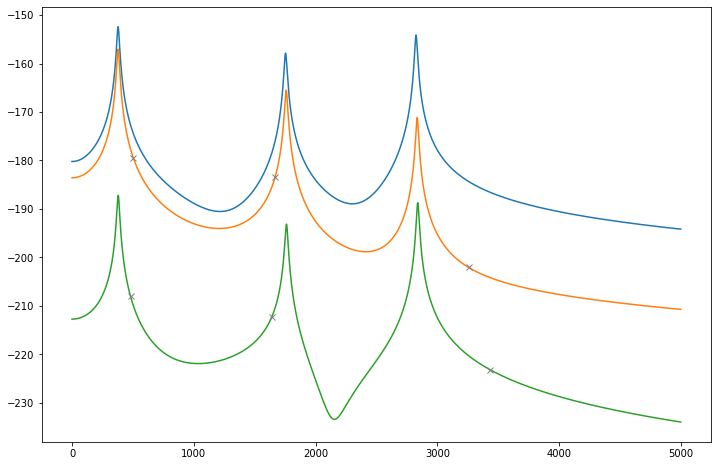

In [11]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

## Higher $K$